In [286]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shap

from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from sklearn.ensemble import RandomForestRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from skll.metrics import spearman, pearson

RANDOM_STATE = 420
N_JOBS = 8

In [251]:
%matplotlib inline

workdir = "/Users/youngsun/repos/github/perftasks/ML/interpretability/tutorials/IMLwPython"

statspath = os.path.join(workdir, "clubb_stats.csv")
stats_df = pd.read_csv(statspath, sep=",")
etime_unit = stats_df[' Selected Instance Median (ms)'].iloc[0]*1.E-6
#etime_unit = stats_df[' Selected Instance Median (ms)'].iloc[0]

datapath = os.path.join(workdir, "clubb_folding.csv")
column_names = ["region", "group", "papi", "timestamp", "value", "accum_value"]

data_df = pd.read_csv(datapath, sep=";", names=column_names)

data_df = data_df.drop('accum_value', axis=1)

regions = {}
for region, df_region in data_df.groupby(['region', 'group']):
    regions[region] = df_region.drop(['region', 'group', 'timestamp'], axis=1)

if len(regions) == 0:
    print("No region is found in data file.")
    data_df = None
elif len(regions) > 1:
    print("More than one regions are found. Picked a region randomly.")
    data_df = regions[next(iter(regions))]
else:
    data_df = regions[next(iter(regions))]

data_df = data_df[data_df.papi.str.endswith('_per_ins') == False]
data_df = data_df.set_index([data_df.groupby('papi').cumcount(), 'papi']).value.unstack()
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.interpolate()
data_df = data_df.loc[:, (data_df != 0).any(axis=0)]
data_df.index.rename('time', inplace=True)


#data_df['etime'] = etime_unit
#data_df['etime'] = np.random.randint(1, 6, data_df.shape[0])

# check if exist nan, inf values
#print(data_df[data_df.isin([np.nan, np.inf, -np.inf]).any(1)])

# check data values
#data_df.head()

#data_df.plot()
#for title, group in data_df.groupby('papi'):
#    group.plot(x='timestamp', y='value', title=title)

# Get the data for the position we want, in this case it's DE
#pos_df = data_df2.loc[data_df2.Pos=='DE'].copy().reset_index(drop=True)

In [295]:
# what we want to predict
#target = 'etime'
target = 'PAPI_RES_STL'

#features = data_df.columns[data_df.columns.str.startswith('PAPI')].values
temp_df = data_df.loc[:, data_df.columns != target]
features = temp_df.columns[temp_df.columns.str.startswith('PAPI')].values
num_features = len(features)

X_df, X_test_df, y_df, y_test_df = train_test_split(
    data_df[features], data_df[target], test_size=0.33,
    random_state=RANDOM_STATE, shuffle=False)

# Split the data into train and test sets
#train_df = pos_df.loc[pos_df.Year <= 2011]
#test_df = pos_df.loc[pos_df.Year.isin([2012, 2013, 2014, 2015])]

X_all = data_df[features].values
y_all = data_df[target].values

X = X_df.values
y = y_df.values

X_test = X_test_df.values
y_test = y_test_df.values

print(X_all.shape)

(999, 55)


In [215]:
# searching best parameter set

# the modeling pipeline
pipe = Pipeline([("imputer", Imputer()),
    ("estimator", RandomForestRegressor(random_state=RANDOM_STATE))])

# We use spearman's rank correlation as the scoring metric since
# we are concerned with ranking the players
spearman_scorer = make_scorer(spearman)
#pearson_scorer = make_scorer(pearson)

# the hyperparamters to search over, including different imputation strategies
rf_param_space = {
   'imputer__strategy': Categorical(['mean', 'median', 'most_frequent']),
   'estimator__max_features': Integer(1, num_features),
   'estimator__n_estimators': Integer(50, 500), 
   'estimator__min_samples_split': Integer(2, 200),
}
# create our search object
search = BayesSearchCV(pipe, 
                    rf_param_space, 
                    cv=10,
                    n_jobs=N_JOBS, 
                    verbose=0, 
                    error_score=-9999,
                    #scoring=spearman_scorer, 
                    random_state=RANDOM_STATE,
                    return_train_score=True, 
                    n_iter=75)

# fit the model
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    search.fit(X, y) 

# best model parameters
print(search.best_params_)

# get the estimator and imputer from our pipeline, which will be used
# as we try and interpret our model
estimator = search.best_estimator_.named_steps['estimator']
imputer = search.best_estimator_.named_steps['imputer']
y_pred = search.predict(X_test)


{'estimator__max_features': 35, 'estimator__min_samples_split': 103, 'estimator__n_estimators': 197, 'imputer__strategy': 'median'}


In [310]:
# in case that we already know the best paramenter set
# saving best paramenter set for clubb data
# {  'estimator__max_features': 31,
#    'estimator__min_samples_split': 1419,
#    'estimator__n_estimators': 2656,
#    'imputer__strategy': 'median'}
#{'estimator__max_features': 31, 'estimator__min_samples_split': 142,
# 'estimator__n_estimators': 287, 'imputer__strategy': 'median'}

#pipe = Pipeline([("imputer", Imputer(strategy='median')), ("estimator",
#    RandomForestRegressor( max_features=31, min_samples_split=1419,
#           n_estimators=2656, random_state=RANDOM_STATE))])

pipe = Pipeline([("imputer", Imputer(strategy='median')), ("estimator",
    RandomForestRegressor( max_features=31, min_samples_split=142,
           n_estimators=287, random_state=RANDOM_STATE))])

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    pipe.fit(X, y)
    
estimator = pipe.named_steps['estimator']
imputer = pipe.named_steps['imputer']
y_pred = pipe.predict(X_test)

print(y_pred[:10])

[590.92265281 397.05380661 346.3785857  343.70053315 341.17431852
 341.17431852 341.17431852 348.65175135 348.65175135 348.65175135]


In [311]:

print(estimator.feature_importances_[:10])
#feature_importances = pd.DataFrame(rf.feature_importances_,
#    index = X_train.columns,
#    columns=['importance']).sort_values('importance',
#    ascending=False)


[1.96571305e-02 8.27735661e-02 8.91557156e-03 1.05100050e-02
 2.20796081e-02 9.11372682e-04 2.87480451e-01 2.28655013e-03
 2.42467420e-04 3.59269211e-04]


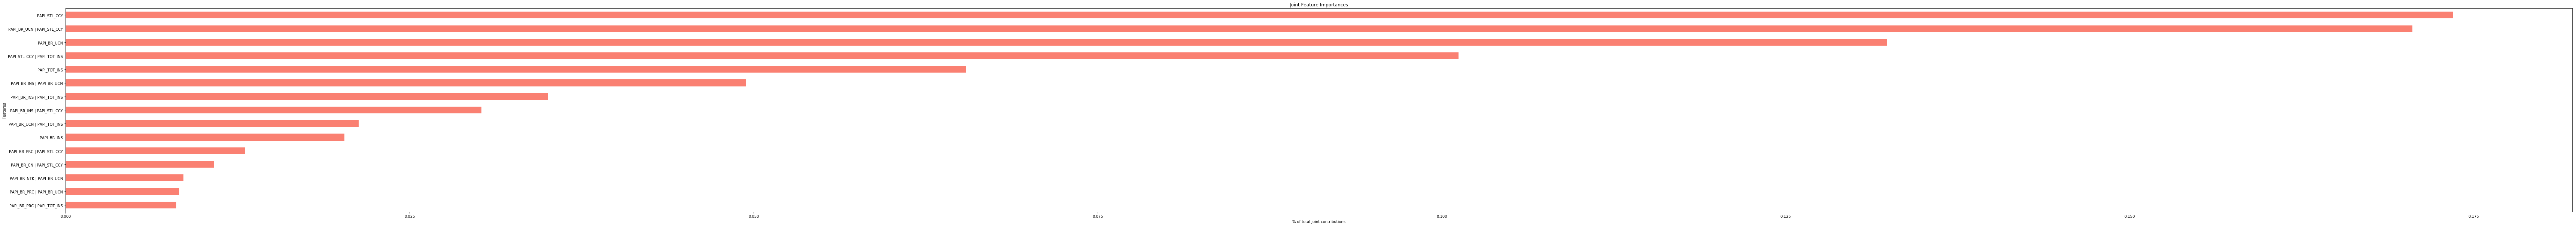

In [319]:
import treeinterpreter.treeinterpreter as ti

test_X_imp = imputer.transform(X_all)

joint_pred, joint_bias, joint_contrib = ti.predict(estimator,
                                                   test_X_imp,
                                                   joint_contribution=True)

def create_ordered_joint_contrib_df(contrib):
    """
    Creates a dataframe from the joint contribution info, where the
    feature combinations are ordered (in descending fashion) by the absolute
    value of the joint contribution.
    """
    df = pd.DataFrame(contrib, columns=['feat_interaction', 'contribution'])
    # get the reordered index    
    new_idx = (df.contribution.abs()
                              .sort_values(inplace=False, ascending=False)
                              .index)
    df = df.reindex(new_idx).reset_index(drop=True)
    return df

# add the names of the feats to the joint contributions
joint_contrib_w_feat_names = []
# for each observation in the join contributions
for obs in joint_contrib:
    # create a list
    obs_contrib = []
    # for each tuple of column indexes
    for k in obs.keys():
        # get the associated feature names
        feature_combo = [features[i] for i in k]
        # get the contribution value
        contrib = obs[k]
        # store that information in the observation individual list
        obs_contrib.append([feature_combo, contrib])
    # append that individual to the large list containing each observations
    # joint feature contributions
    joint_contrib_w_feat_names.append(obs_contrib)

# create an ordered dataframe for each player
joint_contrib_dfs = [create_ordered_joint_contrib_df(contrib)
                     for contrib in joint_contrib_w_feat_names]
# now combine them all
joint_contrib_df = pd.concat(joint_contrib_dfs, keys=features, names=['papi'])

# edit feat_interaction column so the values are strings and not lists
joint_contrib_df['feat_interaction'] = joint_contrib_df.feat_interaction.apply(' | '.join) 

# first get the sum of the absolute values for each joint feature contribution
abs_imp_joint_contrib = (joint_contrib_df.groupby('feat_interaction')
                                          .contribution
                                          .apply(lambda x: x.abs().sum())
                                           .sort_values(ascending=False))

# then calculate the % of total contribution by dividing by the sum of all absolute vals
rel_imp_join_contrib = abs_imp_joint_contrib / abs_imp_joint_contrib.sum()

rel_imp_join_contrib.head(15)[::-1].plot(kind='barh', color='salmon', 
                                              title='Joint Feature Importances');
plt.ylabel('Features')
plt.xlabel('% of total joint contributions');

In [312]:
spearman_scorer = make_scorer(spearman)
#pearson_scorer = make_scorer(pearson)

# evaluation
model_test_score = spearman_scorer(pipe, X_test, y_test)
#model_test_score = pearson_scorer(pipe, X_test, y_test)
print(model_test_score)

# create percentiles for nfl draft picks
# Lower numerical picks (e.g. 1, 2, 3) are ranked closer to 1
# Higher numerical picks (e.g. 180, 200, etc) are ranked closer to 0
#draft_pick_pctile = test_df.Pick.rank(pct=True,
#                                      method='min', 
#                                      ascending=False, 
#                                      na_option='top')
#spearman(y_test, draft_pick_pctile)


0.9264475082998502


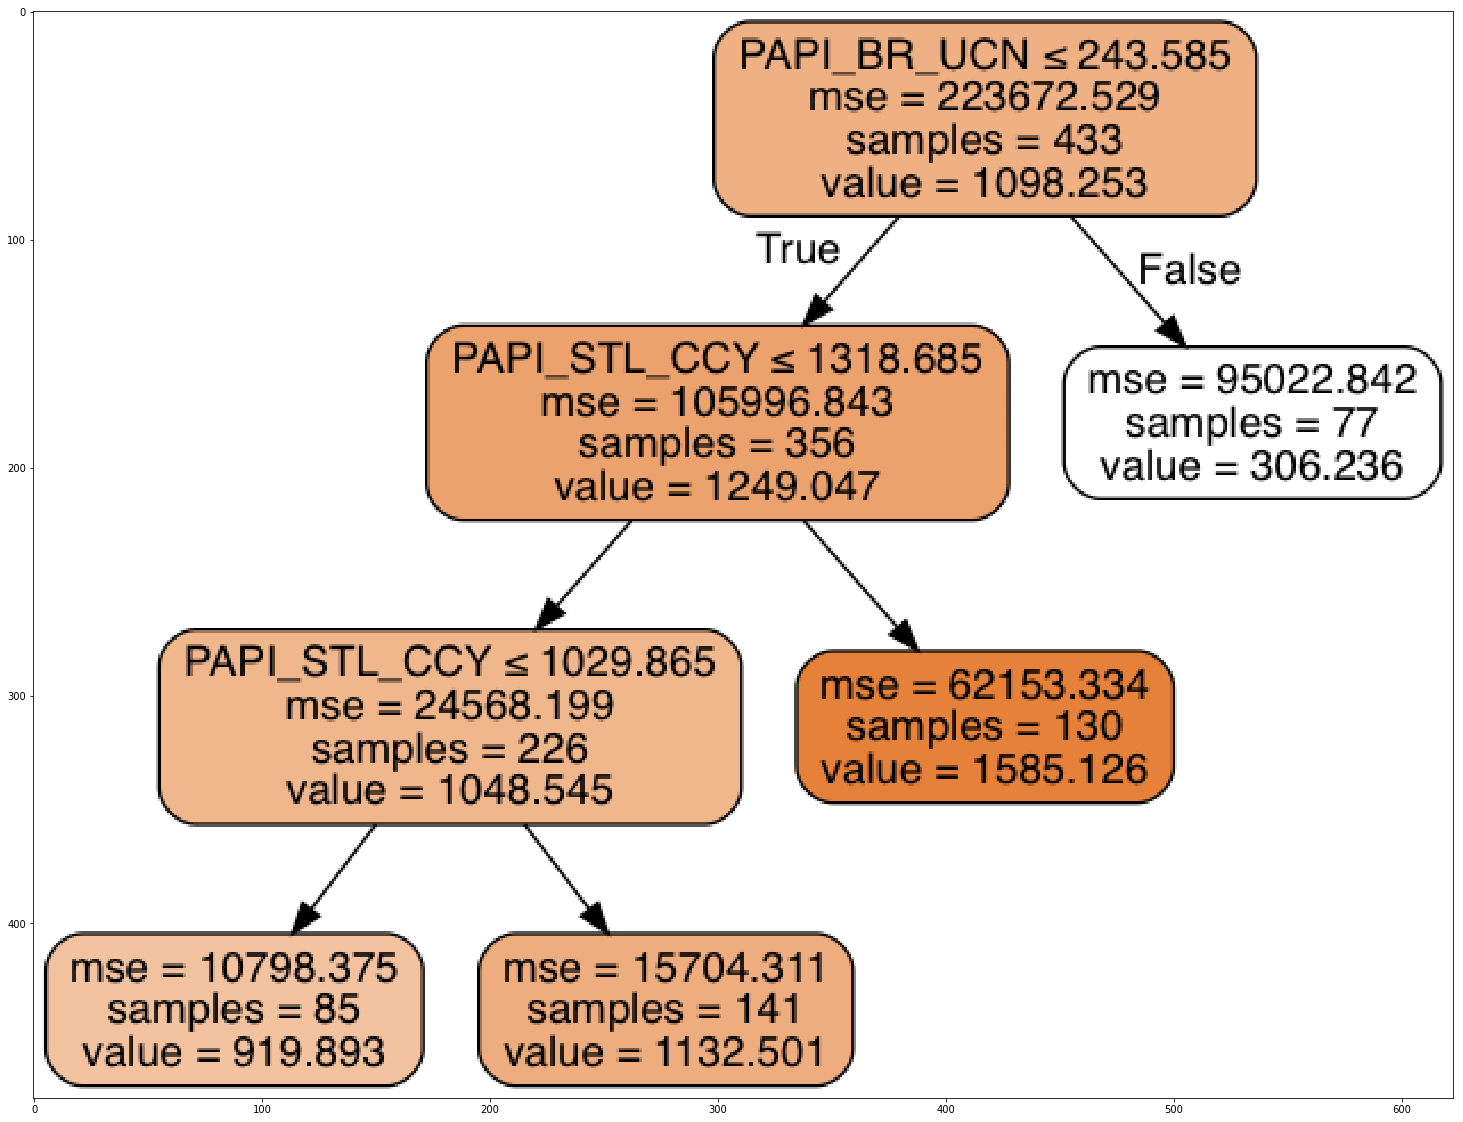

In [304]:
from io import StringIO, BytesIO
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
import matplotlib.image as mpimg

plt.rcParams['figure.figsize'] = [30, 20]

# Get all trees of depth 2 in the random forest
#depths2 = [tree for tree in estimator.estimators_ if tree.tree_.max_depth==2]
depths2 = [tree for tree in estimator.estimators_]

# grab the first one
treeid = np.random.randint(0, len(depths2))
tree = depths2[treeid]


# plot the tree
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data, feature_names=features,
                filled=True, rounded=True, special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
png_str = graph.create_png(prog='dot')

# treat the dot output string as an image file
bio = BytesIO()
bio.write(png_str)
bio.seek(0)
img = mpimg.imread(bio)

# plot the image
imgplot = plt.imshow(img, aspect='equal')

# simple exmaple of a player with a 4.6 Forty and a Wt of 260 lbs
#example = np.array([4.6, 260, 0, 0, 0, 0, 0, 0])
#eli5.explain_prediction_df(tree, example, feature_names=self.features)

#example_prec = tree.predict(example.reshape(1,-1))

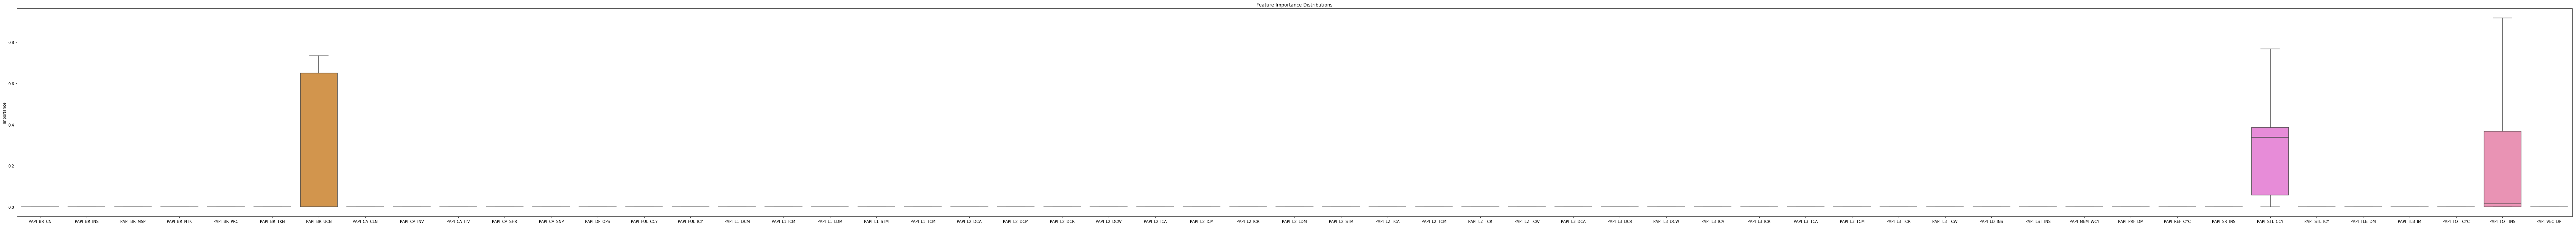

In [313]:
import eli5
import seaborn as sns

plt.rcParams['figure.figsize'] = [120, 10]

# create our dataframe of feature importances
feat_imp_df = eli5.explain_weights_df(estimator, feature_names=features)
feat_imp_df
# get the feature importances from each tree and then visualize the
# distributions as boxplots
all_feat_imp_df = pd.DataFrame(data=[tree.feature_importances_ for tree in 
                                     estimator],
                               columns=features)

(sns.boxplot(data=all_feat_imp_df, showfliers=False)
        .set(title='Feature Importance Distributions',
             ylabel='Importance'));

In [314]:

# create our SHAP explainer
shap_explainer = shap.TreeExplainer(estimator)

test_X_imp = imputer.transform(X_all)

# calculate the shapley values for our test set
test_shap_vals = shap_explainer.shap_values(test_X_imp)

# load JS in order to use some of the plotting functions from the shap
# package in the notebook
shap.initjs()


test_X_imp_df = pd.DataFrame(test_X_imp, columns=features)

# get the prediction and actual target values to plot
#y_test_and_pred_df = pd.DataFrame(np.column_stack((y_test, y_pred)),
#    index=X_test_df.index,
#    columns=['true_etime', 'pred_etime'])




In [315]:
# plot the explanation for a single prediction
#shap.force_plot(test_shap_vals[0, :], test_X_imp_df.iloc[0, :])
#shap.force_plot(test_X_imp_df.iloc[0, :], test_shap_vals[0, :])

# visualize the first prediction's explanation
shap.force_plot(shap_explainer.expected_value, test_shap_vals[0,:], test_X_imp_df.iloc[0,:])

In [316]:
shap.force_plot(shap_explainer.expected_value, test_shap_vals[:,:], test_X_imp_df.iloc[:,:])

PAPI_BR_CN  PAPI_BR_INS  PAPI_BR_MSP  PAPI_BR_NTK  PAPI_BR_PRC  \
0        0.0000       0.0000     0.765062      24.0939      0.00000   
1        0.0000       0.0000     0.765022      24.0709      0.00000   
2        0.0000       0.0000     0.764944      24.0249      0.00000   
3        0.0000       0.0000     0.764827      23.9559      0.00000   
4       12.9942       0.0000     0.764670      23.8638      8.91843   
5       83.8277       0.0000     0.764474      23.7487     83.05080   
6       84.1191       0.0000     0.764239      23.6106     83.34230   
7       84.4664      61.3822     0.764064      23.4482     83.68970   
8       84.8945     170.8750     0.764308      23.2566     84.11740   
9       85.4289     172.5900     0.765806      23.0316     84.65010   
10      86.1069     174.7730     0.769747      22.7684     85.32410   
11      86.9357     177.4470     0.776324      22.4665     86.14620   
12      87.9151     180.6100     0.785536      22.1256     87.11650   
13      89.0478     184.2690     0.797422      21.7464     88.23750   
14      90.3642     188.4760     0.812328      21.3339     89.53910   
15      91.9216     193.3190     0.830826      20.9011     91.07810   
16      93.7579     198.8420     0.853143      20.4605     92.89220   
17      95.9076     205.0680     0.879236      20.0276     95.01570   
18      98.4021     211.9960     0.909688      19.6203     97.47960   
19     101.2590     219.5970     0.944741      19.2532    100.30100   
20     104.4840     227.8490     0.984388      18.9347    103.48700   
21     108.0890     236.7170     1.028630      18.6783    107.04800   
22     112.0850     246.1600     1.077290      18.5002    110.99400   
23     116.4780     256.1370     1.130170      18.4155    115.33500   
24     121.2740     266.5200     1.186590      18.4561    120.07400   
25     126.4730     277.2060     1.246130      18.6473    125.21400   
26     132.0820     288.0230     1.308680      19.0281    130.76000   
27     138.1070     298.7650     1.373950      19.6446    136.72000   
28     144.5530     309.3640     1.441770      20.5136    143.09800   
29     151.4360     319.7640     1.512060      21.6537    149.91100   
..          ...          ...          ...          ...          ...   
969    285.9250     503.3330     1.441760     127.9520    284.40500   
970    296.6930     528.5200     1.540850     135.3400    295.07000   
971    306.1570     552.4140     1.652020     142.0040    304.42000   
972    314.3230     575.0140     1.775310     147.9460    312.45800   
973    321.2970     596.2980     1.910920     153.2250    319.29300   
974    327.3160     616.1960     2.052910     157.9630    325.16900   
975    332.6000     634.6530     2.192060     162.2640    330.31200   
976    337.3120     651.6480     2.323970     166.1920    334.89400   
977    341.5670     667.2580     2.447300     169.8050    339.02900   
978    345.3710     681.5000     2.560680     173.0970    342.72400   
979    348.7190     694.2560     2.665360     176.0550    345.97200   
980    351.6070     705.3360     2.763580     178.6660    348.76600   
981    354.0360     714.7220     2.855590     180.9280    351.10800   
982    356.0060     722.4140     2.941380     182.8420    352.99800   
983    357.5200     728.4220     3.020920     184.4090    354.43600   
984    358.6250     732.9520     3.093390     185.6600    355.47300   
985    359.4160     736.3710     3.158570     186.6610    356.20200   
986    360.0070     739.0330     3.217980     187.4960    356.73700   
987    360.4900     741.2050     3.272830     188.2330    357.16700   
988    360.9230     743.1530     3.323130     188.9040    357.55200   
989    361.3170     744.9240     3.368850     189.5150    357.90200   
990    361.6720     746.5180     3.410010     190.0640    358.21700   
991    361.9870     747.9350     3.446590     190.5520    358.49700   
992    362.2630     749.1750     3.478600     190.9800    358.74200   
993    362.4990     750.2380 

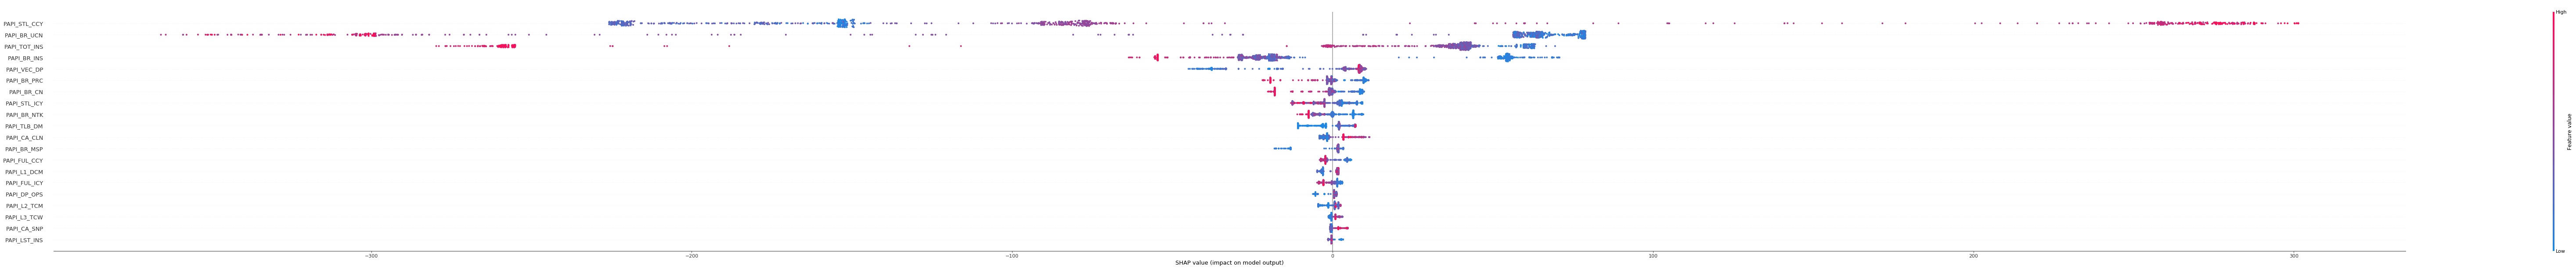

In [317]:
shap.summary_plot(test_shap_vals, test_X_imp_df, auto_size_plot=False)

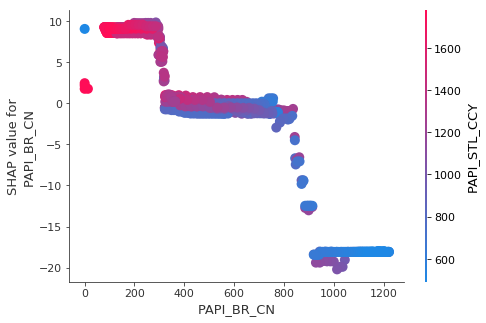

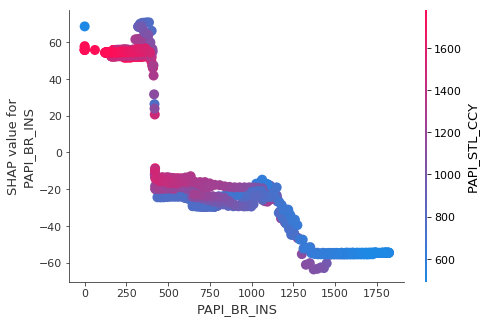

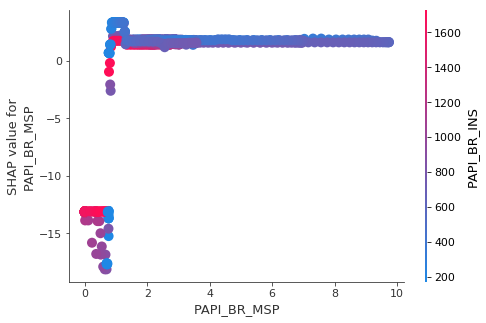

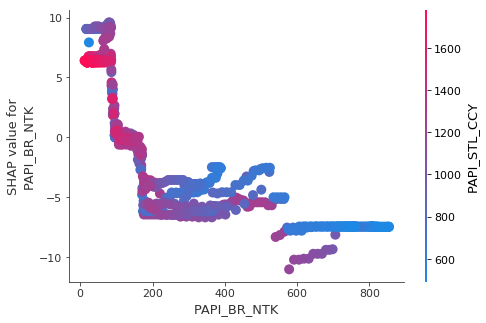

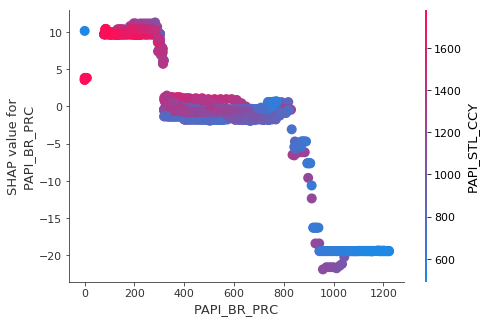

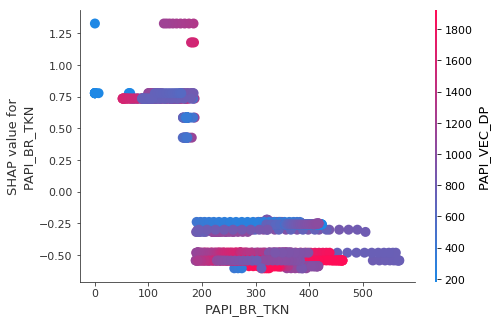

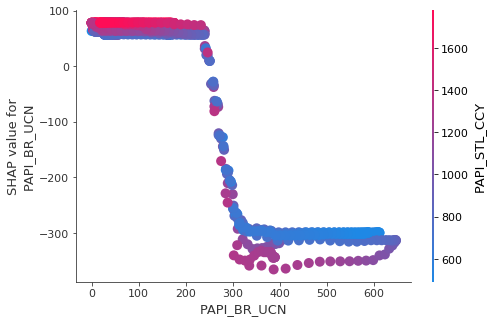

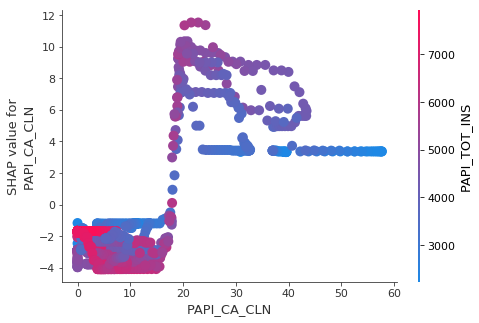

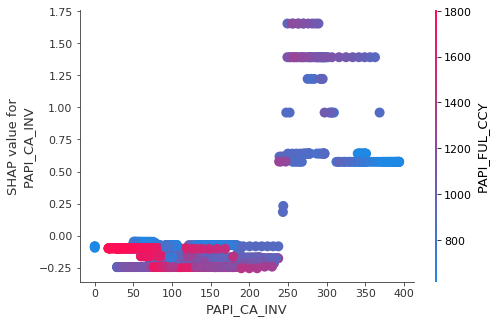

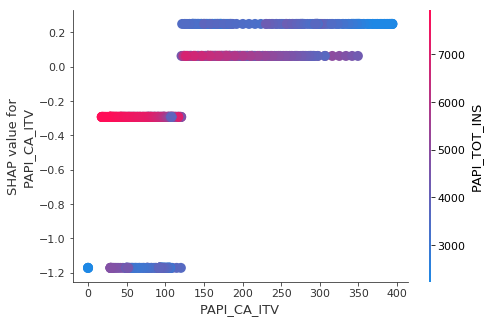

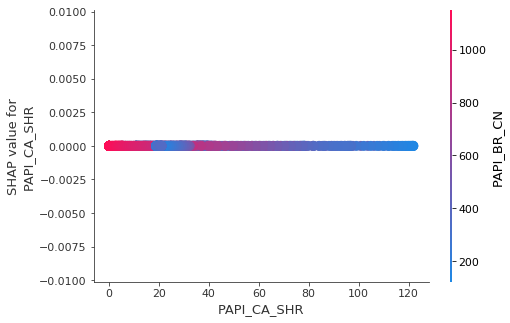

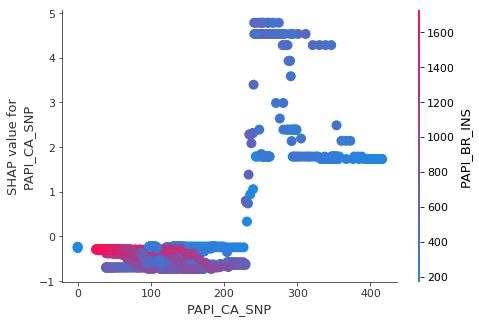

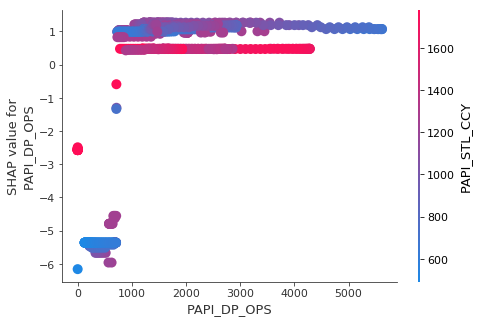

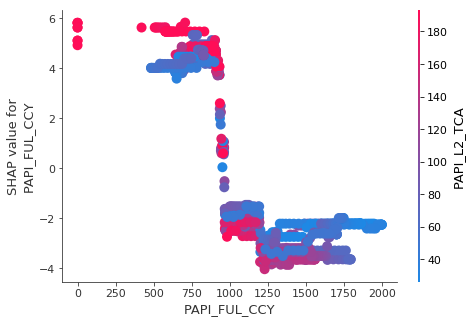

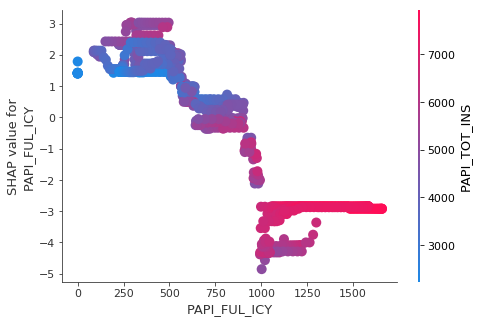

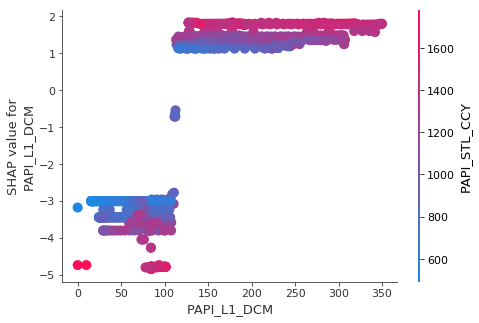

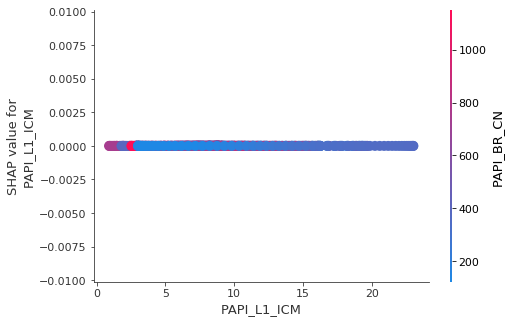

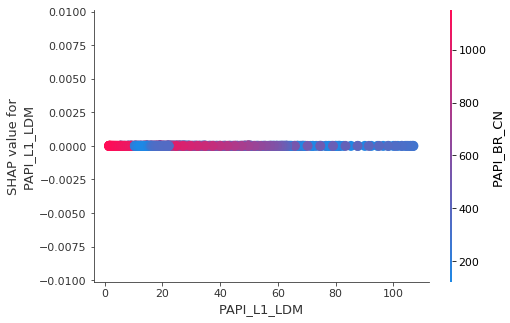

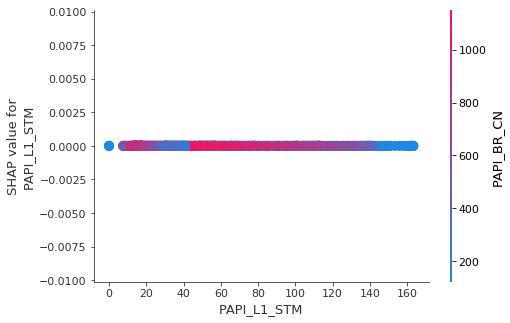

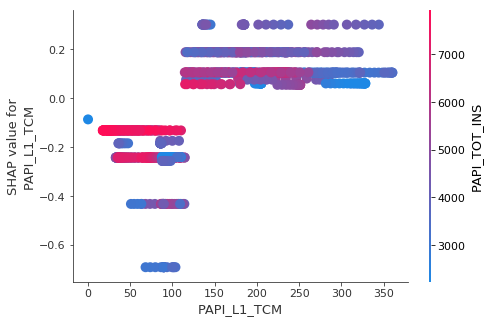

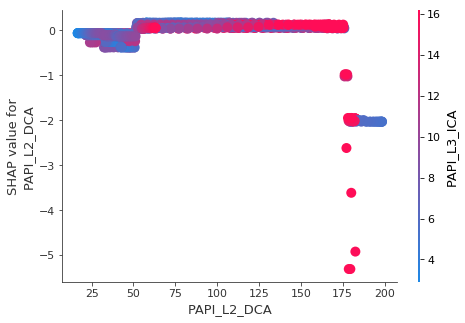

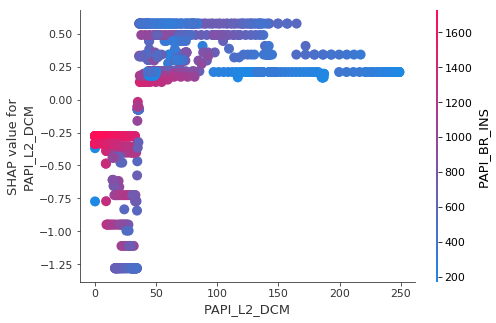

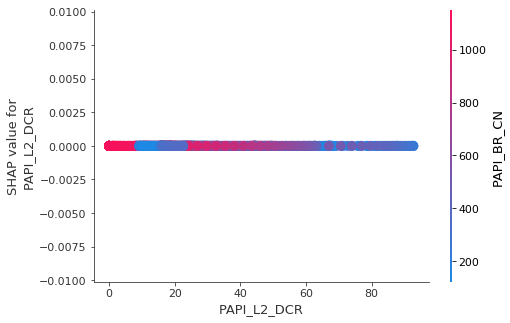

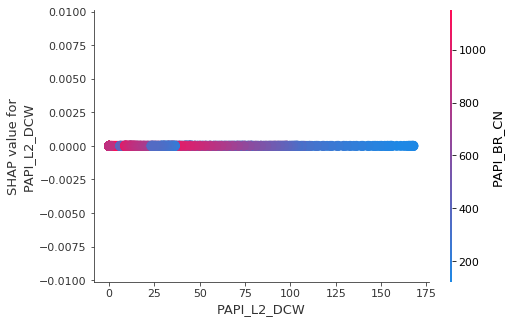

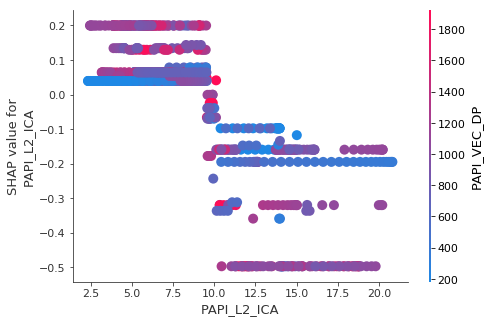

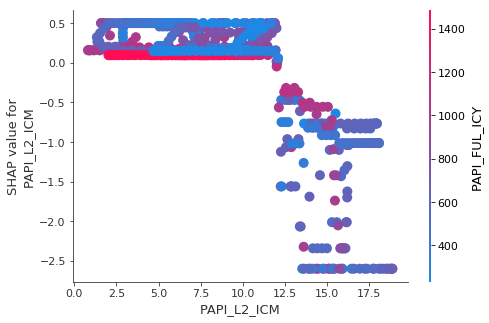

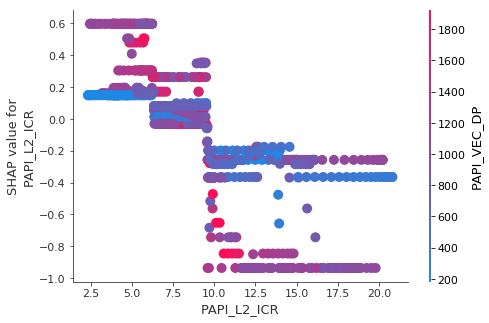

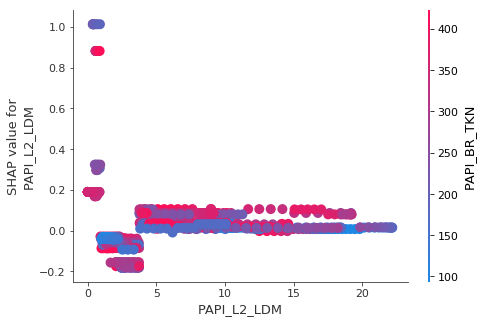

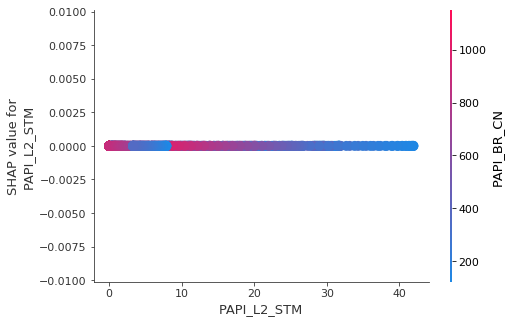

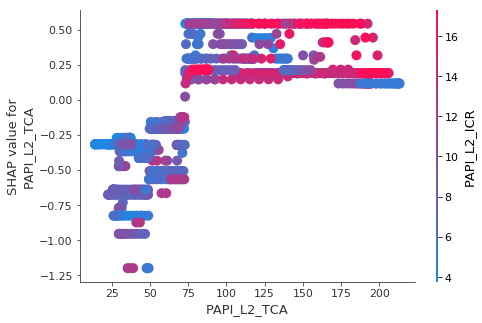

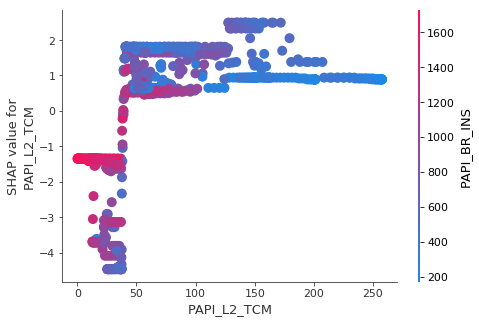

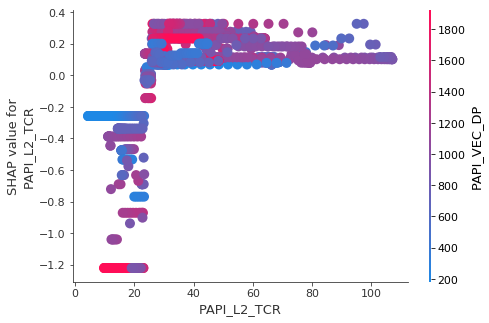

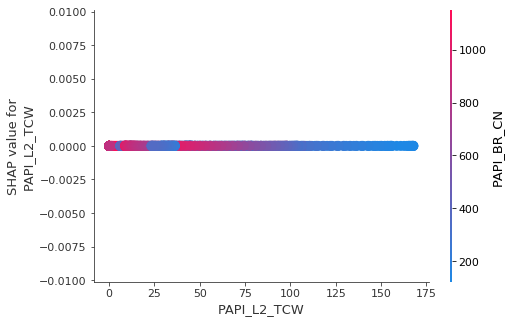

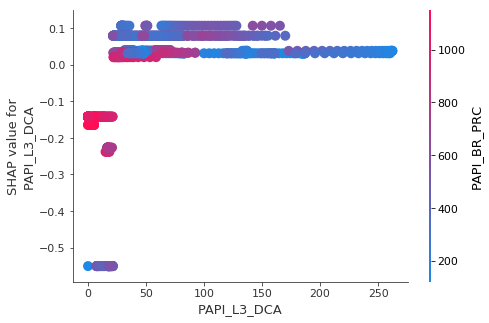

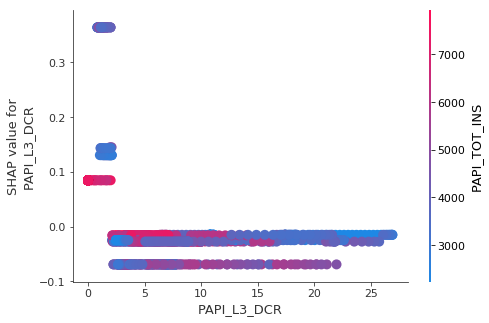

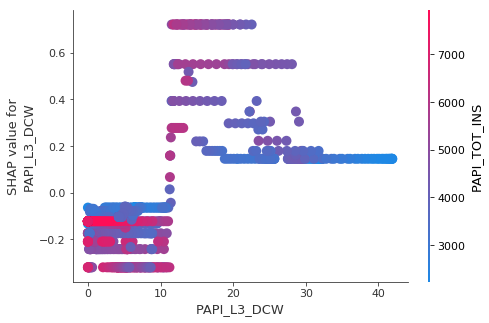

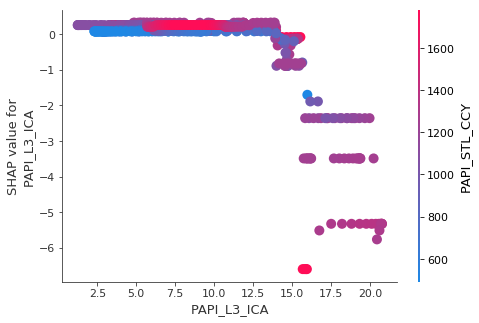

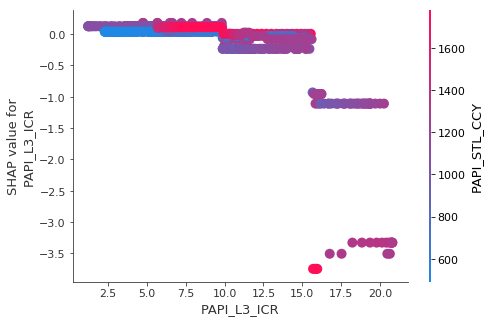

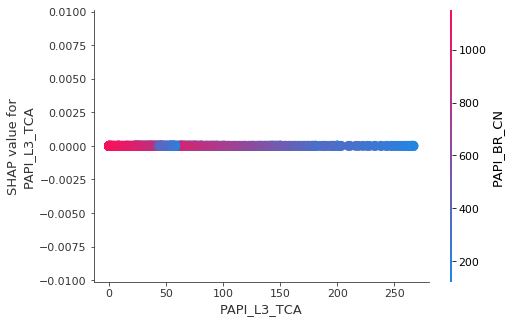

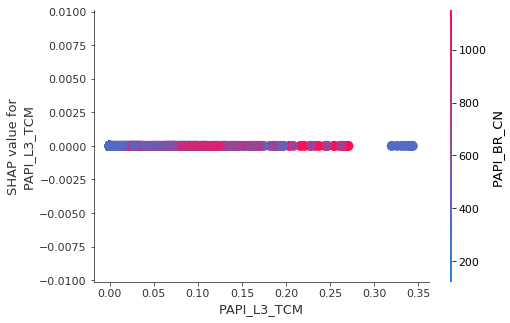

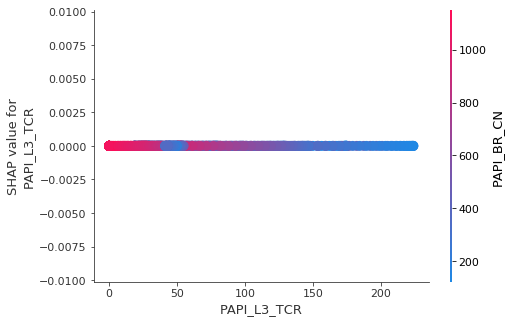

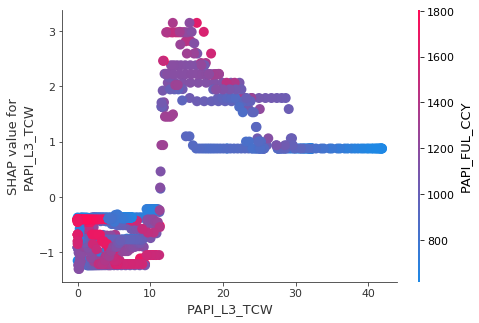

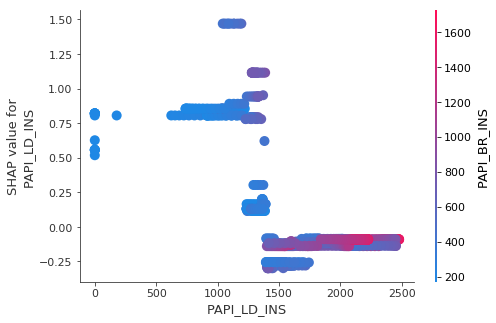

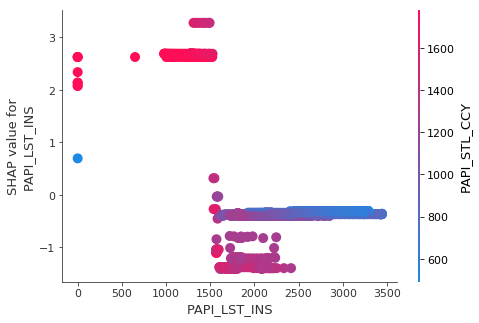

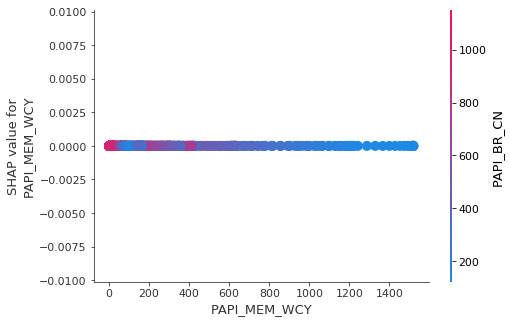

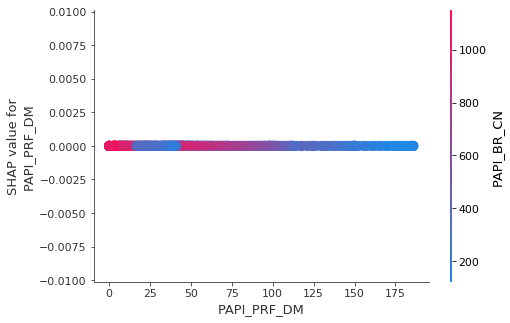

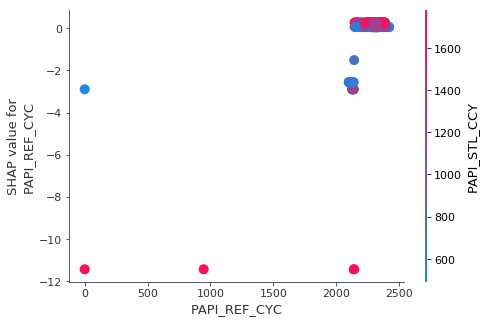

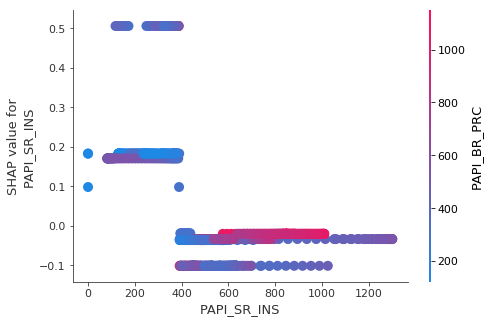

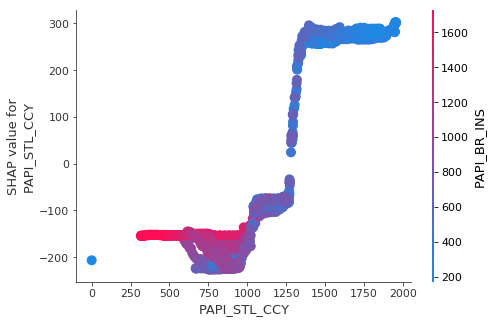

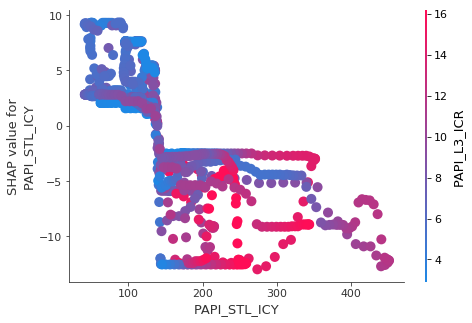

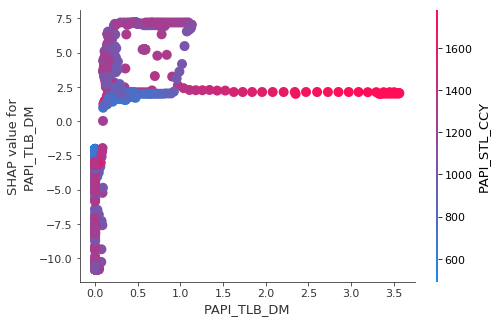

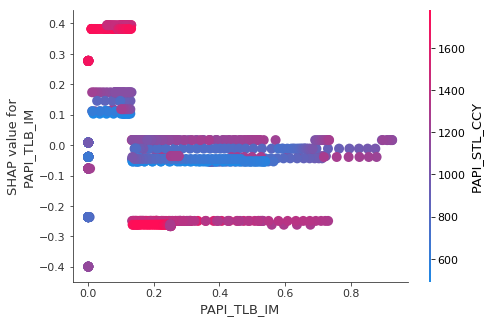

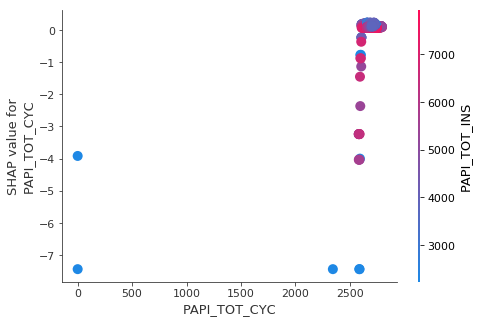

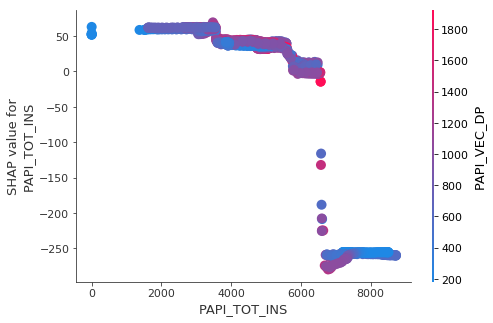

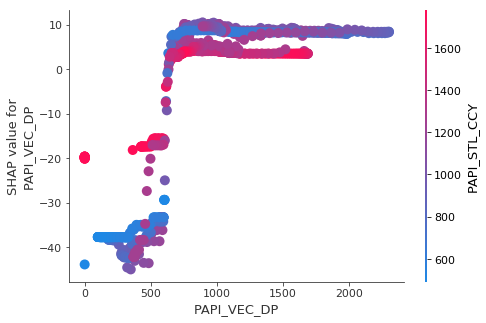

In [318]:
for feat in features:
    shap.dependence_plot(feat, test_shap_vals, test_X_imp_df, dot_size=100)

In [38]:

test_shap_df = pd.DataFrame(np.column_stack((test_shap_vals, y_test_and_pred_df)),
                            columns= features + ['true_AV_pctile', 
                                                 'pred_AV_pctile'])
test_shap_df.sort_values('pred_AV_pctile', inplace=True)


title = 'SHAP Values for each prediction in the testing data'
# NOTE: this plot work only in command line
#fig = double_heatmap(test_shap_df[['true_AV_pctile', 'pred_AV_pctile']].T,
#                     test_shap_df[features].T, '%ile', 'SHAP Value',
#                     title=title, subplot_top=0.89)
#fig.axes[1].set_xlabel('Player');